# RandomForest5


## Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.tree import export_text, plot_tree
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, OrdinalEncoder


# Load dataset
df = pd.read_csv('/content/drive/MyDrive/NTL/bioinformatika/data_preprasi_AMPK (1).csv')
df.head()

,MW,LogP,NumHDonors,NumHAcceptors,pIC50,class_numeric,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,...,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880,NumHDonors.1,NumHAcceptors.1
0,398.482,3.33494,3,3,7.207608,0,1,1,1,0,...,0,0,0,0,0,0,0,0,3,3
1,484.431,6.54092,2,6,6.000000,0,1,1,1,0,...,0,0,0,0,0,0,0,0,2,6
2,386.858,4.77030,1,5,5.000000,1,1,1,1,0,...,0,0,0,0,0,0,0,0,1,5
3,502.978,2.79240,2,8,5.000000,1,1,1,1,0,...,0,0,0,0,0,0,0,0,2,8
4,486.979,3.55440,2,7,5.000000,1,1,1,1,0,...,0,0,0,0,0,0,0,0,2,7



Target Distribution:

class_numeric
1    141
0     33
Name: count, dtype: int64


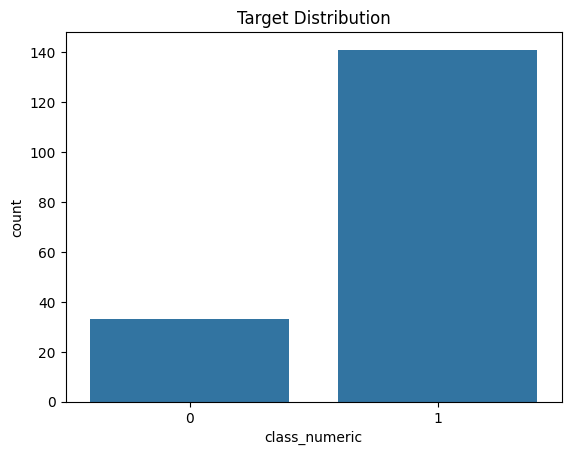

In [ ]:
# Target Distribution
print("\nTarget Distribution:\n")
print(df['class_numeric'].value_counts())
sns.countplot(x='class_numeric', data=df)
plt.title("Target Distribution")
plt.show()

## Model

In [ ]:
# Split dataset
X = df.drop(columns=['class_numeric'])
y = df['class_numeric']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y,random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((139, 888), (35, 888), (139,), (35,))

## pipeline

In [ ]:
#pipeline numerik
numerical_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy='mean')),
    ("scaler", MinMaxScaler())
])

In [ ]:
#pipeline categorical
categorical_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy='most_frequent')),
    ("ordinal_encoder", OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])


In [ ]:
numeric = ["MW","LogP","NumHDonors","NumHAcceptors"]
categoric = [col for col in X_train.columns if col not in numeric]

preprocessor = ColumnTransformer([
    ("numeric", numerical_pipeline, numeric),
    ("categoric", categorical_pipeline,categoric)
])

In [ ]:
pipeline = Pipeline([
    ("prep", preprocessor),
    ("algo", RandomForestClassifier())
])

parameter = {
    "algo__n_estimators": [100, 200, 300],         # Jumlah pohon dalam hutan
    "algo__max_depth": [10, 20, 30],             # Kedalaman maksimum pohon
    "algo__min_samples_split": [2, 5, 10],             # Minimum sampel untuk split
    "algo__min_samples_leaf": [1, 2, 4],               # Minimum sampel di tiap daun
    "algo__max_features": ['sqrt', 'log2'],      # Jumlah fitur yang dipertimbangkan untuk split
}



In [ ]:
model = GridSearchCV(pipeline, param_grid=parameter, cv=3, n_jobs=-1, verbose=1)
model.fit(X_train, y_train)

Fitting 3 folds for each of 162 candidates, totalling 486 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('prep',
                                        ColumnTransformer(transformers=[('numeric',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          MinMaxScaler())]),
                                                                         ['MW',
                                                                          'LogP',
                                                                          'NumHDonors',
                                                                          'NumHAcceptors']),
                                                                        ('categoric',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('ordinal_encoder',
                                                                                          OrdinalEncoder(handle_unknown='use_enco...
                                                                          'PubchemFP21',
                                                                          'PubchemFP22',
                                                                          'PubchemFP23',
                                                                          'PubchemFP24',
                                                                          'PubchemFP25',
                                                                          'PubchemFP26',
                                                                          'PubchemFP27',
                                                                          'PubchemFP28', ...])])),
                                       ('algo', RandomForestClassifier())]),
             n_jobs=-1,
             param_grid={'algo__max_depth': [10, 20, 30],
                         'algo__max_features': ['sqrt', 'log2'],
                         'algo__min_samples_leaf': [1, 2, 4],
                         'algo__min_samples_split': [2, 5, 10],
                         'algo__n_estimators': [100, 200, 300]},
             verbose=1)

In [ ]:
# evaluation
print(model.best_params_)
print(model.best_estimator_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

{'algo__max_depth': 10, 'algo__max_features': 'log2', 'algo__min_samples_leaf': 1, 'algo__min_samples_split': 2, 'algo__n_estimators': 100}
Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['MW', 'LogP', 'NumHDonors',
                                                   'NumHAcceptors']),
                                                 ('categoric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                 

## Evaluasi

In [ ]:
# Classification Report
y_pred = model.predict(X_test)
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))


Classification Report:

              precision    recall  f1-score   support

           0       0.80      0.57      0.67         7
           1       0.90      0.96      0.93        28

    accuracy                           0.89        35
   macro avg       0.85      0.77      0.80        35
weighted avg       0.88      0.89      0.88        35



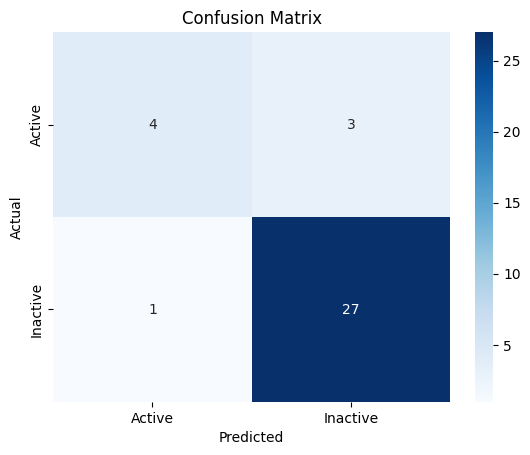

In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Active', 'Inactive'], yticklabels=['Active', 'Inactive'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

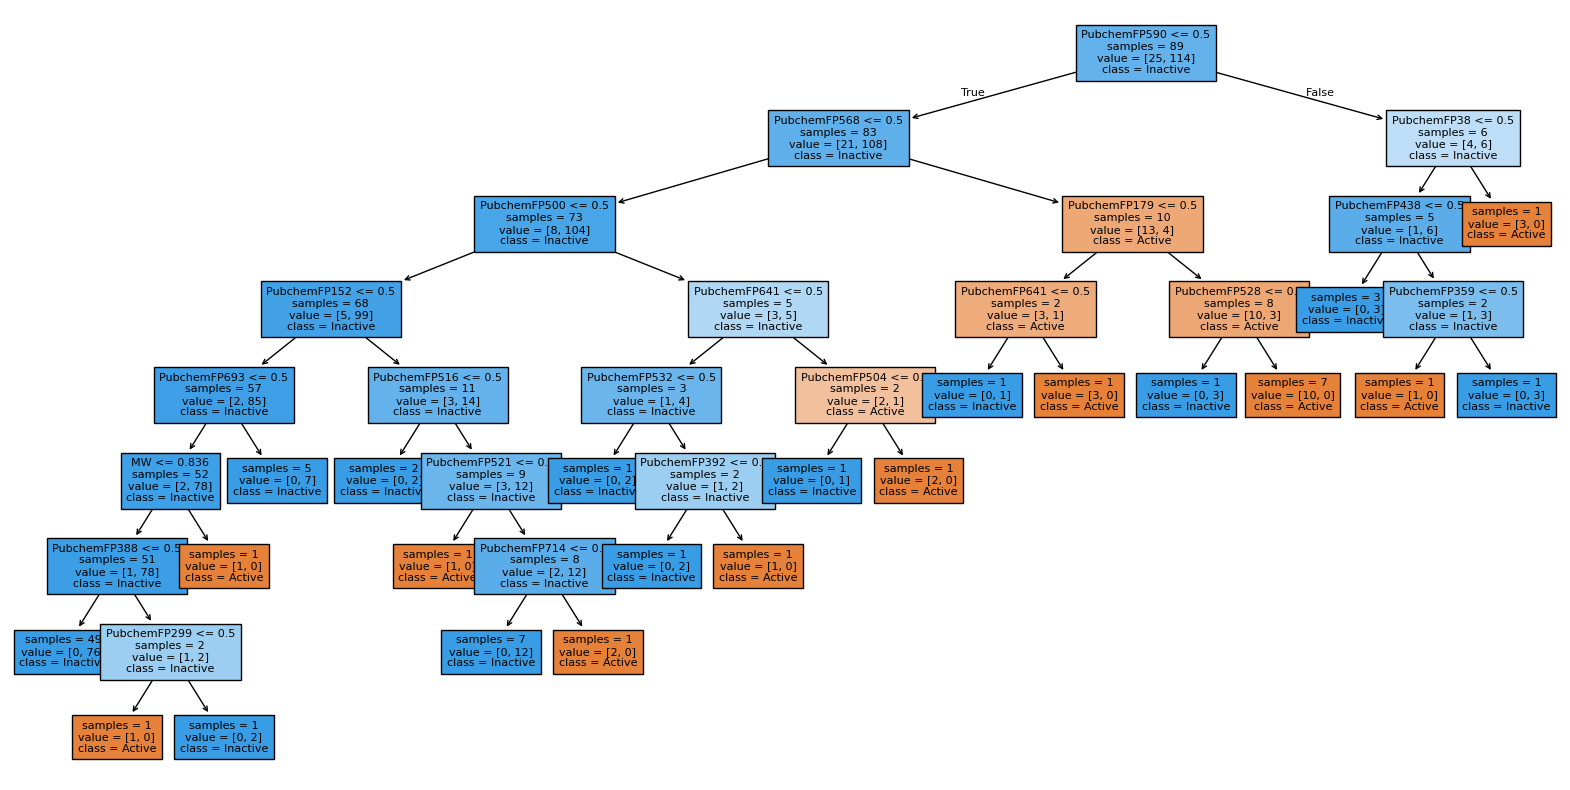

In [ ]:
# Visualize a Decision Tree
# print("\nDecision Tree Example:\n")

plt.figure(figsize=(20, 10))
# Access the DecisionTreeClassifier within the Pipeline
plot_tree(model.best_estimator_['algo'].estimators_[1], # Access the 'algo' step (RandomForestClassifier) and then the first tree
          feature_names=X.columns,
          class_names=['Active', 'Inactive'],
          filled=True,
          impurity=False,
          fontsize=8)
plt.show()

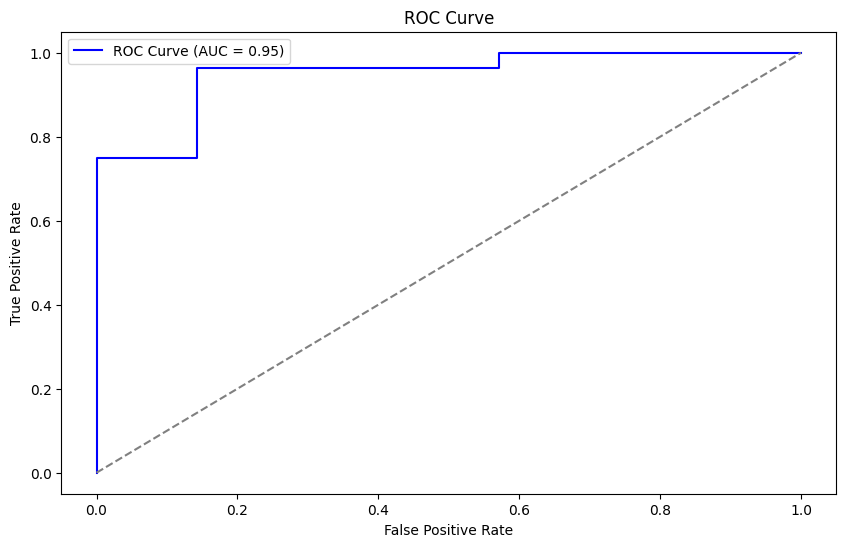

In [ ]:
# ROC and AUC Curve
y_prob = model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

In [ ]:
#fitur importance
# Mendapatkan fitur penting
# Access the feature importances from the best estimator
importances = model.best_estimator_['algo'].feature_importances_
feature_names = X_train.columns if hasattr(X_train, "columns") else range(X_train.shape[1])

# Membuat visualisasi atau menampilkan fitur penting
import pandas as pd
import matplotlib.pyplot as plt

# Menyusun data fitur dan kepentingannya
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Menampilkan fitur penting
print(feature_importance_df)


          Feature  Importance
0              MW    0.036099
573  PubchemFP568    0.030960
199  PubchemFP194    0.030567
200  PubchemFP195    0.026850
4           pIC50    0.025820
..            ...         ...
233  PubchemFP228    0.000000
234  PubchemFP229    0.000000
235  PubchemFP230    0.000000
236  PubchemFP231    0.000000
468  PubchemFP463    0.000000

[888 rows x 2 columns]


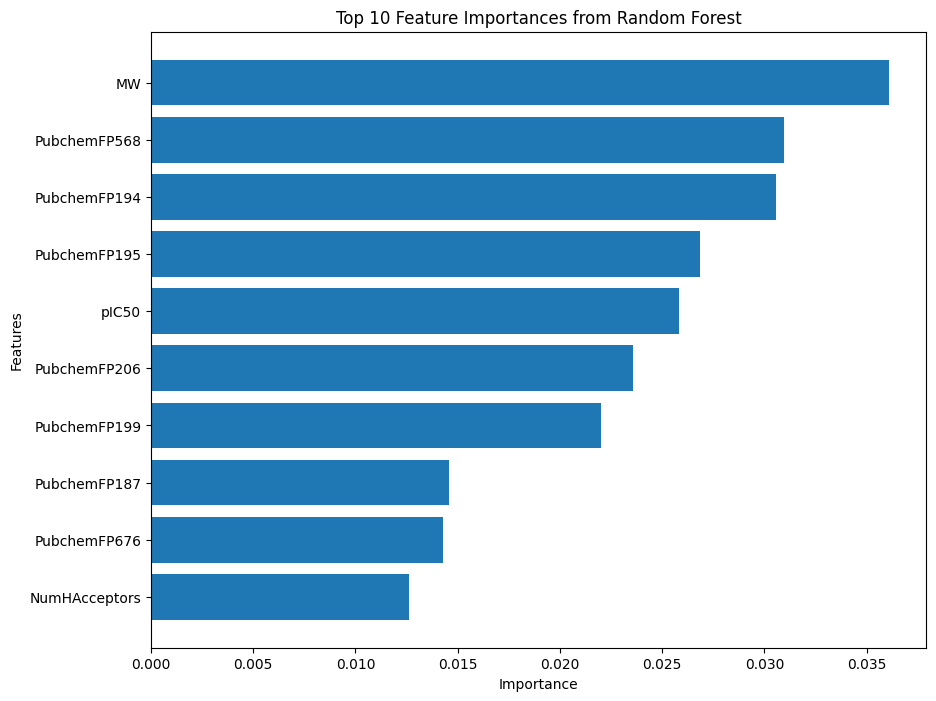

In [ ]:

# Visualisasi fitur penting (hanya 10 fitur teratas)
plt.figure(figsize=(10, 8))  # Ukuran gambar yang lebih sesuai
top_10_features = feature_importance_df.head(10)
plt.barh(top_10_features['Feature'], top_10_features['Importance'])
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Top 10 Feature Importances from Random Forest')
plt.gca().invert_yaxis()
plt.show()

## Predict

In [ ]:

# Prediction Function
def predict_molecule(input_data):
    """Predict the class of a molecule (Active or Inactive)."""
    input_df = pd.DataFrame([input_data], columns=X.columns)
    prediction = model.predict(input_df)
    probability = model.predict_proba(input_df)
    class_map = {0: 'Active', 1: 'Inactive'}
    return {
        'Prediction': class_map[prediction[0]],
        'Probability': {
            'Active': probability[0][0],
            'Inactive': probability[0][1]
        },
        'Input Data': input_data
    }

In [ ]:
# Example Prediction
example_molecule = X.iloc[0].to_dict()  # Replace with your custom input data
result = predict_molecule(example_molecule)
print("Example Prediction:\n")
print("Prediction:", result['Prediction'])
print("Probability:", result['Probability'])
print("Input Data:", result['Input Data'])

Example Prediction:

Prediction: Active
Probability: {'Active': 0.6278804855275443, 'Inactive': 0.37211951447245567}
Input Data: {'MW': 398.48200000000014, 'LogP': 3.3349400000000013, 'NumHDonors': 3.0, 'NumHAcceptors': 3.0, 'pIC50': 7.207608310501746, 'PubchemFP0': 1.0, 'PubchemFP1': 1.0, 'PubchemFP2': 1.0, 'PubchemFP3': 0.0, 'PubchemFP4': 0.0, 'PubchemFP5': 0.0, 'PubchemFP6': 0.0, 'PubchemFP7': 0.0, 'PubchemFP8': 0.0, 'PubchemFP9': 1.0, 'PubchemFP10': 1.0, 'PubchemFP11': 1.0, 'PubchemFP12': 1.0, 'PubchemFP13': 0.0, 'PubchemFP14': 1.0, 'PubchemFP15': 1.0, 'PubchemFP16': 1.0, 'PubchemFP17': 0.0, 'PubchemFP18': 1.0, 'PubchemFP19': 1.0, 'PubchemFP20': 0.0, 'PubchemFP21': 0.0, 'PubchemFP22': 0.0, 'PubchemFP23': 1.0, 'PubchemFP24': 0.0, 'PubchemFP25': 0.0, 'PubchemFP26': 0.0, 'PubchemFP27': 0.0, 'PubchemFP28': 0.0, 'PubchemFP29': 0.0, 'PubchemFP30': 0.0, 'PubchemFP31': 0.0, 'PubchemFP32': 0.0, 'PubchemFP33': 0.0, 'PubchemFP34': 0.0, 'PubchemFP35': 0.0, 'PubchemFP36': 0.0, 'PubchemFP37': 0.

## Save Model

In [ ]:
# Save the trained model
model_filename = 'random_forest_model.pkl'
joblib.dump(model, model_filename)
print(f"Model saved to {model_filename}")

Model saved to random_forest_model.pkl
